In [10]:
import pandas as pd
features = pd.read_csv('../../../4 - Data/04_WorkingDatasets/Top50CombLagged/50CombLagged.csv') #Top 50 Feature + comination Features + Lagged Target
target = pd.read_csv('../../../4 - Data/04_WorkingDatasets/Top50CombLagged/TargetOutliersTreated.csv')
import numpy as np
import random
random.seed(11)
np.random.seed(11)

In [11]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from joblib import Parallel, delayed

# Ensure the features and target dataframes are correctly assigned
features = features.drop(columns=['Datum'])
target = target['PM10_Combined_Trend_Residual']

# Split the data into train, test, and validate sets
train_data, temp_data, train_target, temp_target = train_test_split(features, target, test_size=0.3, random_state=42)
test_data, validate_data, test_target, validate_target = train_test_split(temp_data, temp_target, test_size=0.3333, random_state=42)

# Add squared features
features_squared = features ** 2
features = pd.concat([features, features_squared.add_suffix('_squared')], axis=1)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Save the scaler using pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Update the train, test, and validate sets with the scaled features
train_data, temp_data, train_target, temp_target = train_test_split(features_scaled, target, test_size=0.3, random_state=42)
test_data, validate_data, test_target, validate_target = train_test_split(temp_data, temp_target, test_size=0.3333, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'eta0': [0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'penalty': ['l2', 'l1', 'elasticnet', None]
}

# Initialize the SGDRegressor
sgd = SGDRegressor(max_iter=1000, tol=1e-3)

# Initialize GridSearchCV
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(train_data, train_target.values.ravel())

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Plot the progress bar
progress_bar = tqdm(total=100)
for i in range(100):
    progress_bar.update(1)
progress_bar.close()

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the model on the test set
predictions = grid_search.predict(test_data)
predictions = np.maximum(predictions, 0)  # Ensure predictions are not lower than zero
mse = mean_squared_error(test_target, predictions)
print("Mean Squared Error on Test Set:", mse)

# Evaluate the model on the validation set
validate_predictions = grid_search.predict(validate_data)
validate_predictions = np.maximum(validate_predictions, 0)  # Ensure predictions are not lower than zero
validate_mse = mean_squared_error(validate_target, validate_predictions)
print("Mean Squared Error on Validation Set:", validate_mse)

# Expanding CV Fold Sizes
initial_train_size = int(0.5 * len(train_data))
test_size = int(0.1 * len(train_data))
num_folds = (len(train_data) - initial_train_size) // test_size

def train_and_evaluate_fold(fold):
    start_train_size = initial_train_size + fold * test_size
    end_train_size = start_train_size + test_size

    X_train_fold = train_data[:end_train_size]
    y_train_fold = train_target[:end_train_size]
    X_test_fold = train_data[end_train_size:end_train_size + test_size]
    y_test_fold = train_target[end_train_size:end_train_size + test_size]

    model = SGDRegressor(**best_params, max_iter=1000, tol=1e-3)
    model.fit(X_train_fold, y_train_fold)
    fold_predictions = model.predict(X_test_fold)
    fold_predictions = np.maximum(fold_predictions, 0)  # Ensure predictions are not lower than zero
    fold_mse = mean_squared_error(y_test_fold, fold_predictions)
    return fold, fold_mse

results = Parallel(n_jobs=-1)(delayed(train_and_evaluate_fold)(fold) for fold in range(num_folds))

for fold, fold_mse in results:
    print(f"Fold {fold + 1}/{num_folds}, MSE: {fold_mse}")

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV] END alpha=0.0001, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.0001, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.0001, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.001, learning_rate=constant, penalty=None; total time=   0.1s
[CV] END alpha=0.0001, eta0=0.001,

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  25.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  25.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  26.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  27.2s
[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  27.1s
[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=   7.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  36.6s
[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  37.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  37.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  34.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasin

[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  34.1s
[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  33.4s
[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  23.4s
[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  23.1s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.4s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  34.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.5s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.6s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.8s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.6s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.7s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=None; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=constant, penalty=elasticnet; total tim

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  34.5s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=l2; total time=   0.6s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=l2; total time=   3.1s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=l1; total time=   0.6s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=l2; total time=   3.2s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=l1; total time=   4.5s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=l1; total time=   4.2s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=l1; total time=   5.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  36.5s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   2.0s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=l1; total time=   4.7s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   3.3s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=None; total time=   1.5s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=None; total time=   0.2s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=None; total time=   1.0s
[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  15.9s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=invscaling, penalty=l2; total time=   0.3s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   3.9s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total t

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  25.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  26.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=  24.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=  24.5s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=  24.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=  25.0s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=  25.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  37.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  37.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  38.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  40.5s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  40.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  39.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  41.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  42.0s
[CV] END alpha=0.0001, eta0=1, learning_rate=constant, penalty=l2; total time=   0.4s
[CV] END alpha=0.0001, eta0=1, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.0001, eta0=1, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.0001, eta0=1, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=constant, penalty=l1; total time=   0.6s
[CV] END alpha=0.0001, eta0=1, learning_rate=constant, penalty=l1; total time=   0.5s
[CV] END alpha=0.0001, eta0=1, learning_rate

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  29.2s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=l2; total time=   2.1s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=l2; total time=   1.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=l2; total time=   1.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  41.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=l2; total time=   2.5s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=l2; total time=   2.5s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=l1; total time=   3.2s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=l1; total time=   2.6s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=l1; total time=   4.7s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   1.7s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=l1; total time=   3.4s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=l1; total time=   3.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  42.4s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   1.8s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   3.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   3.5s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   4.1s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=None; total time=   2.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  27.3s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  27.4s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=None; total time=   2.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  27.7s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=None; total time=   3.2s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.9s
[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=None; total time=   2.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.8s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=l2; total time=   1.1s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.5s
[CV] END alpha=0.0001, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  26.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=optimal, penalty=None; total time=   2.6s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=l2; total time=   1.5s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   1.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=l1; total time=   2.0s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=l1; total time=   2.2s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=l1; total time=   2.4s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   2.6s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=l1; total time=   3.2s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=None; total time=   1.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   2.5s
[CV] END alpha=0.0001, eta0=1, learning_rate=invscaling, penalty=None; total time=   0.8s
[CV] 

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=l2; total time=  28.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=l2; total time=  29.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=l2; total time=  30.2s
[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=l2; total time=  30.0s
[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=l2; total time=  30.1s
[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=l1; total time=   9.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=l1; total time=  41.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=l1; total time=  41.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=l1; total time=  42.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  42.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=l1; total time=  43.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  42.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=None; total time=  30.6s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  44.0s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.4s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.4s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.6s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=None; total time=  32.1s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.5s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=None; total time=   0.2s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=None; total time=   0.5s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=None; total time=   0.5s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penalty=None; total time=   0.7s
[CV] END alpha=0.001, eta0=0.001, learning_rate=constant, penal

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  47.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=   1.5s
[CV] END alpha=0.001, eta0=0.001, learning_rate=optimal, penalty=None; total time=   0.2s
[CV] END alpha=0.001, eta0=0.001, learning_rate=optimal, penalty=None; total time=   0.2s
[CV] END alpha=0.001, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=   1.8s
[CV] END alpha=0.001, eta0=0.001, learning_rate=optimal, penalty=None; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=optimal, penalty=None; total time=   0.4s
[CV] END alpha=0.001, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   0.2s
[CV] END alpha=0.001, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=   2.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   0.4s
[CV] END alpha=0.001, eta0=0.001, learning_rate=optimal, penalty=elasticnet;

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.001, learning_rate=invscaling, penalty=l1; total time=   0.3s
[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  46.9s
[CV] END alpha=0.001, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=invscaling, penalty=None; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   1.6s
[CV] END alpha=0.001, eta0=0.001, learning_rate=invscaling, penalty=None; total time=   0.2s
[CV] END alpha=0.001, eta0=0.001, learning_rate=invscaling, penalty=None; total time=   0.3s
[CV] END alpha=0.001, eta0=0.001, learning_rate=i

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=None; total time=  31.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.0001, eta0=1, learning_rate=adaptive, penalty=None; total time=  31.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  24.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  25.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  25.6s
[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  25.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  26.2s
[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=   8.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  33.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  35.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  33.7s
[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  33.7s
[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  34.5s
[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  34.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasin

[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  34.2s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  23.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.5s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.6s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  24.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.9s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=None; total time=   0.2s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=None; total time=   0.2s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=None; total time=   0.3s
[CV] END alpha=0.001, eta0=0.1, learning_rate=constant, penalty=None; total time=   

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  35.9s
[CV] END alpha=0.001, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   1.2s
[CV] END alpha=0.001, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   1.5s
[CV] END alpha=0.001, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   2.3s
[CV] END alpha=0.001, eta0=0.1, learning_rate=optimal, penalty=None; total time=   0.4s
[CV] END alpha=0.001, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   1.4s
[CV] END alpha=0.001, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   1.4s
[CV] END alpha=0.001, eta0=0.1, learning_rate=optimal, penalty=None; total time=   1.1s
[CV] END alpha=0.001, eta0=0.1, learning_rate=optimal, penalty=None; total time=   0.8s
[CV] END alpha=0.001, eta0=0.1, learning_rate=optimal, penalty=None; total time=   1.2s
[CV] END alpha=0.001, eta0=0.1, learning_rate=invscaling, penalty=l2; total time= 

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  36.9s
[CV] END alpha=0.001, eta0=0.1, learning_rate=invscaling, penalty=elasticnet; total time=   0.6s
[CV] END alpha=0.001, eta0=0.1, learning_rate=invscaling, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0.001, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.4s
[CV] END alpha=0.001, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.8s
[CV] END alpha=0.001, eta0=0.1, learning_rate=invscaling, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0.001, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.5s
[CV] END alpha=0.001, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.4s
[CV] END alpha=0.001, eta0=0.1, learning_rate=invscaling, penalty=elasticnet; total time=   1.7s
[CV] END alpha=0.001, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  25.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  26.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=  25.8s
[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=  25.7s
[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=  25.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=  25.9s
[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=  26.1s
[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  37.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  40.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  41.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  41.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  41.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  42.6s
[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  42.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  42.8s
[CV] END alpha=0.001, eta0=1, learning_rate=constant, penalty=l2; total time=   0.7s
[CV] END alpha=0.001, eta0=1, learning_rate=constant, penalty=l2; total time=   0.5s
[CV] END alpha=0.001, eta0=1, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.001, eta0=1, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.001, eta0=1, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.001, eta0=1, learning_rate=constant, penalty=l1; total time=   0.4s
[CV] END alpha=0.001, eta0=1, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.001, eta0=1, learning_rate=constant, penalty=l1; total time=   0.6s
[CV] END alpha=0.001, eta0=1, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.001, eta0=1, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.001, eta0=1, learning_rate=constant, p

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  28.3s
[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  43.8s
[CV] END alpha=0.001, eta0=1, learning_rate=optimal, penalty=l2; total time=   1.1s
[CV] END alpha=0.001, eta0=1, learning_rate=optimal, penalty=l1; total time=   0.3s
[CV] END alpha=0.001, eta0=1, learning_rate=optimal, penalty=l1; total time=   0.9s
[CV] END alpha=0.001, eta0=1, learning_rate=optimal, penalty=l1; total time=   1.7s
[CV] END alpha=0.001, eta0=1, learning_rate=optimal, penalty=l1; total time=   1.3s
[CV] END alpha=0.001, eta0=1, learning_rate=optimal, penalty=l1; total time=   1.5s
[CV] END alpha=0.001, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   1.5s
[CV] END alpha=0.001, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   2.0s
[CV] END alpha=0.001, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   2.1s
[CV] END alpha=0.001, eta0=1, learni

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   0.5s
[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  39.4s
[CV] END alpha=0.001, eta0=1, learning_rate=invscaling, penalty=l1; total time=   1.7s
[CV] END alpha=0.001, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   1.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  26.3s
[CV] END alpha=0.001, eta0=1, learning_rate=invscaling, penalty=None; total time=   1.3s
[CV] END alpha=0.001, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   1.6s
[CV] END alpha=0.001, eta0=1, learning_rate=invscaling, penalty=None; total time=   0.2s
[CV] END alpha=0.001, eta0=1, learning_rate=invscaling, penalty=None; total time=   0.9s
[CV] END alpha=0.001, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   2.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  25.8s
[CV] END alpha=0.001, eta0=1, learning_rate=invscaling, penalty=None; total time=   1.0s
[CV] END alpha=0.001, eta0=1, learning_rate=invscaling, penalty=None; total time=   1.4s
[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  26.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  27.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=l2; total time=  26.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=l2; total time=  25.9s
[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=l2; total time=  26.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=l2; total time=  26.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=l2; total time=  26.8s
[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=l1; total time=  10.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=l1; total time=  37.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=l1; total time=  38.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=l1; total time=  37.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  38.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=None; total time=  26.5s
[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  38.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  39.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=l1; total time=  39.8s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=None; total time=  27.2s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.4s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=l1; total time=   1.0s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=None; total time=   0.2s
[CV] END alpha=0.01, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.3s

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  39.0s
[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=   1.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  40.8s
[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=   2.2s
[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=None; total time=   1.3s
[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=None; total time=   1.1s
[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=None; total time=   0.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=None; total time=  29.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.001, eta0=1, learning_rate=adaptive, penalty=None; total time=  30.1s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   0.4s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   0.4s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   0.3s
[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=None; total time=   1.8s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   0.3s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=l1; total time=   0.7s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=l1; total time=   0.4s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   1.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=l2; total time=  29.8s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=l1; total time=   2.8s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=l1; total time=   2.3s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=l1; total time=   2.7s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=None; total time=   0.2s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=None; total time=   0.2s
[CV] END alpha=0.01, eta0=0.001, learning_rate=invscaling, penalty=

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=l1; total time=  41.0s
[CV] END alpha=0.01, eta0=0.001, learning_rate=adaptive, penalty=None; total time=   0.7s
[CV] END alpha=0.01, eta0=0.001, learning_rate=adaptive, penalty=elasticnet; total time=   2.1s
[CV] END alpha=0.01, eta0=0.001, learning_rate=adaptive, penalty=None; total time=   0.8s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.001, learning_rate=adaptive, penalty=None; total time=   0.7s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.01, eta0

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=l1; total time=  41.7s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=elasticnet; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=elasticnet; total time=   0.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=None; total time=  28.5s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=None; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=elasticnet; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=None; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=None; total time=   0.1s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=None; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=constant, penalty=None; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=l2; total time=   0.4s
[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=l2; total time=   0.4s
[CV] END 

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=  40.8s
[CV] END alpha=0.01, eta0=0.001, learning_rate=adaptive, penalty=None; total time=   4.4s
[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=l1; total time=   0.7s
[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=elasticnet; total time=   1.1s
[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=elasticnet; total time=   1.0s
[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=elasticnet; total time=   0.8s
[CV] END alpha=0.01, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=  37.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=l1; total time=   4.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=None; total time=   0.5s
[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=None; total time=   1.1s
[CV] END alpha=0.01, eta0=0.01, learning_rate=invscaling, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=None; total time=   0.8s
[CV] END alpha=0.01, eta0=0.01, learning_rate=invscaling, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=invscaling, penalty=l2; total time=   0.1s
[CV] END alpha=0.01, eta0=0.01, learning_rate=invscaling, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=invscaling, penalty=l2; total time=   0.4s
[CV] END alpha=0.01, eta0=0.01, learning_rate=invscaling, penalty=l1; total time=   0.2s
[CV] END alpha=0.01, eta0=0.01, learning_rate=invscaling, penalty=l1; total time=   0.2s
[CV] END alpha=0.01, eta0=0

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=l2; total time=  29.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=None; total time=  29.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=None; total time=  28.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  28.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  29.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=l1; total time=  39.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=l1; total time=  39.6s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=   8.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=optimal, penalty=elasticnet; total time=  39.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  27.4s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  19.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=  27.1s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  18.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  43.3s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  42.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  43.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  44.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  45.9s
[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=None; total time=   6.9s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.5s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.7s
[CV] END alpha=0.01, eta0=0.1, learning_ra

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  42.1s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=None; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=None; total time=   0.1s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=None; total time=   0.4s
[CV] END alpha=0.01, eta0=0.1, learning_rate=constant, penalty=None; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=l2; total time=   0.4s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=l2; total time=   0.6s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=l2; total time=   0.7s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=l2; total time=   0.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  43.1s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=l1; total time=   0.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  27.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  29.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  27.4s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   0.9s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   2.5s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   0.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  26.5s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   1.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=None; total time=   0.4s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=None; total time=   1.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  40.5s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=None; total time=   1.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=l2; total time=  28.5s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=l2; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=l2; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=l2; total time=   0.5s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=l1; total time=   0.2s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=l1; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=l1; total time=   0.2s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=l1; total time=   0.2s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=l1; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, lear

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.2s
[CV] END alpha=0.01, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=l1; total time=  31.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=None; total time=  17.0s
[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=l1; total time=  28.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=None; total time=  16.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=l1; total time=  27.8s
[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=   2.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=  24.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=  10.3s
[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=   9.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=   9.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=   9.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  13.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  13.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  13.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  13.5s
[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=   3.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  14.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  14.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  14.3s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=l2; total time=   0.6s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=l1; total time=   0.1s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=l1; total time=   0.1s
[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=ela

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=None; total time=   0.1s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=None; total time=   0.1s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=None; total time=   0.1s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=None; total time=   0.1s
[CV] END alpha=0.01, eta0=1, learning_rate=constant, penalty=None; total time=   0.1s
[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=l2; total time=   0.1s
[CV] END alpha=0.01, eta0=1

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  11.3s
[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=l1; total time=   0.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  11.4s
[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=l1; total time=   0.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  10.9s
[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   0.6s
[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   0.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=  15.6s
[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   0.6s
[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=None; total time=   0.3s
[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=None; total time=   0.1s
[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=None; total time=   0.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  10.9s
[CV] END alpha=0.01, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  11.3s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.4s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.4s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.5s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.4s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.3s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=l1; total time=   0.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=l2; total time=  10.3s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=l1; total time=   0.7s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=l1; total time=   0.9s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=l1; total time=   1.0s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=l1; total time=   0.7s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   0.6s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   0.5s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   1.2s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=None; total time=   0.4s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   0.9s
[CV] END alpha=

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=None; total time=   0.6s
[CV] END alpha=0.01, eta0=1, learning_rate=invscaling, penalty=None; total time=   0.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=None; total time=  10.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=l1; total time=  14.8s
[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=l1; total time=  15.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=None; total time=  10.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=  14.8s
[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=l2; total time=   3.8s
[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=l1; total time=   4.6s
[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=l2; total time=  10.0s
[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=l2; total time=   9.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=l2; total time=  10.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=l2; total time=  10.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=l1; total time=  14.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=l1; total time=  14.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=l1; total time=  14.0s
[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=   8.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=l1; total time=  14.2s
[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  14.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  14.4s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  14.4s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=l2; total time=   0.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.4s
[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=None; total time=   1.3s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.2s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.4s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.2s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=elasticnet; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=constant, penalty=None; total time=   0.1s
[CV] END a

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=None; total time=  10.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=None; total time=  10.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=None; total time=  10.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  15.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.01, eta0=1, learning_rate=adaptive, penalty=None; total time=  11.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=   0.2s
[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=   0.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=l2; total time=  10.5s
[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=l2; total time=  10.8s
[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=   0.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=l1; total time=  15.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=l1; total time=  14.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=l1; total time=  15.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=l1; total time=  14.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=l1; total time=  14.6s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=None; total time=  10.2s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=l2; total time=   0.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=l1; total time=   0.9s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=l1; total time=   0.7s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=l1; total time=   1.0s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.7s
[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=  14.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.6s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   0.6s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=elasticnet; total time=   1.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=None; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=None; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=None; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=None; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=l2; total time=   0.3s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=l2; total time=   0.3s
[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=elasticnet; total time=  14.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=invscaling, penalty=None; total time=   0.6s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=l2; total time=   0.3s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=l2; total time=   0.3s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=l2; total time=   0.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=None; total time=  10.3s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=l1; total time=   1.2s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=l1; total time=   1.0s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=l1; total time=   1.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=l1; total time=   1.0s
[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=None; total time=  10.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=elasticnet; total time=   0.5s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=elasticnet; total time=   0.5s
[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=None; total time=  10.2s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=l1; total time=   1.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=None; total time=   0.4s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=elasticnet; total time=   0.6s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=None; total time=   0.4s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=None; total time=   0.4s
[CV] END alpha=0.1, eta0=0.01, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.01, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.01, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=None; total time=   0.4s
[CV] END alpha=0.1, eta0=0.01, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.01, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.001, learning_rate=adaptive, penalty=elasticnet; total time=   1.1s
[CV] END alpha=0.1, eta0

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.001, learning_rate=optimal, penalty=None; total time=   9.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=l2; total time=  10.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=l2; total time=  10.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=l2; total time=  10.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=elasticnet; total time=   0.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=l1; total time=  14.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=l1; total time=  14.5s
[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=l1; total time=  14.5s
[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=l1; total time=  14.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=l1; total time=  14.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasin

[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=elasticnet; total time=  14.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=None; total time=  10.0s
[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=None; total time=   9.8s
[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=elasticnet; total time=  14.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=invscaling, penalty=l2; total time=   0.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=None; total time=   9.9s
[CV] END alpha=0.1, eta0=0.01, learning_rate=invscaling, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.01, learning_rate=invscaling, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.01, learning_rate=invscaling, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=elasticnet; total time=  14.6s
[CV] END alpha=0.1, eta0=0.01, learning_rate=invscaling, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=invscaling, penalty=l1; total time=   0.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=invscaling, penalty=l1; total time=   0.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=invscaling, penalty=l1; total time=   0.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=invscaling, penalty=l1; total time=   0.2s
[CV] END alpha=0.1, eta0=0.01, learning_rate=invscaling, penalty=elasticnet; total time=   0.1s
[CV] END alpha=0.1, 

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=   0.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=elasticnet; total time=  14.5s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=   7.8s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=   7.9s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=   8.0s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=l2; total time=   8.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=optimal, penalty=None; total time=  10.3s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=   3.4s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=   1.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  14.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  14.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  14.7s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  12.8s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  13.6s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  12.8s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=l1; total time=  14.8s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=l2; total time=   0.1s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.1s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.1s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.1s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.2s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=l1; total time=   0.4s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.1, eta0=0.1, learning_rate=constant, penalty=elasticnet; total time=   0.2s
[CV] END alpha=0.1, eta0=0.1, lea

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  10.7s
[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=l2; total time=   0.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  10.3s
[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=elasticnet; total time=  14.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  11.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.01, learning_rate=adaptive, penalty=None; total time=  11.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=l2; total time=  10.5s
[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=l2; total time=  10.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=l2; total time=  10.8s
[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=   0.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=l1; total time=  14.9s
[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=l1; total time=  14.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=l1; total time=  14.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=l1; total time=  14.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=l1; total time=  15.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=  14.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=  15.2s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=l2; total time=   0.3s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=l2; total time=   0.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=None; total time=  10.6s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=l2; total time=   0.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=  15.0s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=l1; total time=   0.4s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=l1; total time=   0.3s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=l1; total time=   0.3s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=l1; total time=   0.3s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=l1; total time=   0.5s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=elasticnet; total time=   0.5s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=elasticnet; total time=   0.6s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.2s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=elasticnet; total time=   0.3s
[CV]

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.2s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.3s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.1s
[CV] END alpha=0.1, eta0=0.1, learning_rate=invscaling, penalty=None; total time=   0.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=None; total time=  10.2s
[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=   1.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=elasticnet; total time=  15.7s
[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=   4.1s
[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=   4.5s
[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=   4.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=None; total time=  10.9s
[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=l2; total time=   4.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=optimal, penalty=None; total time=  10.8s
[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=   8.7s
[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=   9.7s
[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=   9.2s
[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=elasticnet; total time=   2.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  16.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  18.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  18.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  18.0s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=l2; total time=   0.3s
[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=l1; total time=  18.5s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=l2; total time=   0.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=l2; total time=   0.2s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=l1; total time=   0.3s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=elasticnet; total time=   0.4s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=elasticnet; total time=   0.6s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=elasticnet; total time=   0.2s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, penalty=None; total time=   0.2s
[CV] END alpha=0.1, eta0=1, learning_rate=constant, p

/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  15.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  16.2s
[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  15.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  13.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=0.1, learning_rate=adaptive, penalty=None; total time=  13.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=l2; total time=  13.3s
[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   0.3s
[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=l2; total time=  13.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=   0.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=l2; total time=  12.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=l1; total time=  16.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=l1; total time=  16.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=l1; total time=  16.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=l1; total time=  16.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=l1; total time=  16.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=  15.7s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.8s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.5s
[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=  16.7s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=elasticnet; total time=  16.4s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.8s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.9s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=l1; total time=   0.6s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=l2; total time=   0.9s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=l1; total time=   0.9s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=l1; total time=   0.6s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=l1; total time=   0.8s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=l1; total time=   1.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=None; total time=  11.2s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   1.4s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   1.1s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=None; total time=   0.3s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=None; total time=   0.3s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   1.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=None; total time=  11.4s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   1.3s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=elasticnet; total time=   1.1s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=None; total time=   0.6s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=None; total time=   0.5s
[CV] END alpha=0.1, eta0=1, learning_rate=invscaling, penalty=None; total time=   0.5s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=None; total time=  11.3s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=l2; total time=   1.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=None; total time=  12.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=optimal, penalty=None; total time=  12.2s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=l1; total time=   2.4s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=l2; total time=  10.9s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=l2; total time=  11.2s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=l2; total time=  11.0s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=l2; total time=  11.9s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=   2.6s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=l1; total time=  16.8s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=l1; total time=  16.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=l1; total time=  16.3s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=l1; total time=  16.3s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=None; total time=   3.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=None; total time=  11.2s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  17.4s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  18.0s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  18.2s
[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=None; total time=  11.1s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=None; total time=  10.9s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=elasticnet; total time=  16.2s


/Users/johannessolibieda/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV] END alpha=0.1, eta0=1, learning_rate=adaptive, penalty=None; total time=   6.7s


100%|██████████| 100/100 [00:00<00:00, 249364.09it/s]


Best Parameters: {'alpha': 0.1, 'eta0': 0.001, 'learning_rate': 'constant', 'penalty': 'l1'}
Best Score: -6.849652993655974
Mean Squared Error on Test Set: 5.462614360360832
Mean Squared Error on Validation Set: 8.381248337852279
Fold 1/5, MSE: 4.731652300452814
Fold 2/5, MSE: 6.887069269438181
Fold 3/5, MSE: 4.885781509647411
Fold 4/5, MSE: 5.30858902406746
Fold 5/5, MSE: 0.5789387401359388


In [12]:
# Define a more focused parameter grid for GridSearchCV based on the best parameters
refined_param_grid = {
    'alpha': [best_params['alpha'] * 0.1, best_params['alpha'], best_params['alpha'] * 10],
    'eta0': [best_params['eta0'] * 0.1, best_params['eta0'], best_params['eta0'] * 10],
    'learning_rate': [best_params['learning_rate']],
    'penalty': [best_params['penalty']]
}

# Initialize a new GridSearchCV with the refined parameter grid
refined_grid_search = GridSearchCV(sgd, refined_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the model with the refined parameter grid
refined_grid_search.fit(train_data, train_target.values.ravel())

# Get the best parameters and best score from the refined search
refined_best_params = refined_grid_search.best_params_
refined_best_score = refined_grid_search.best_score_

# Print the refined best parameters and best score
print("Refined Best Parameters:", refined_best_params)
print("Refined Best Score:", refined_best_score)

# Evaluate the refined model on the test set
refined_predictions = refined_grid_search.predict(test_data)
refined_mse = mean_squared_error(test_target, refined_predictions)
print("Refined Mean Squared Error on Test Set:", refined_mse)

# Evaluate the refined model on the validation set
refined_validate_predictions = refined_grid_search.predict(validate_data)
refined_validate_mse = mean_squared_error(validate_target, refined_validate_predictions)
print("Refined Mean Squared Error on Validation Set:", refined_validate_mse)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END alpha=0.010000000000000002, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.1s
[CV] END alpha=0.010000000000000002, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.1s
[CV] END alpha=0.010000000000000002, eta0=0.0001, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.010000000000000002, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.1s
[CV] END alpha=0.010000000000000002, eta0=0.0001, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.010000000000000002, eta0=0.0001, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.010000000000000002, eta0=0.0001, learning_rate=constant, penalty=l1; total time=   0.2s
[CV] END alpha=0.010000000000000002, eta0=0.001, learning_rate=constant, penalty=l1; total time=   0.1s
[CV] END alpha=0.010000000000000002, eta0=0.01, learning_rate=constant, penalty=l1; total time=   0.1s
[

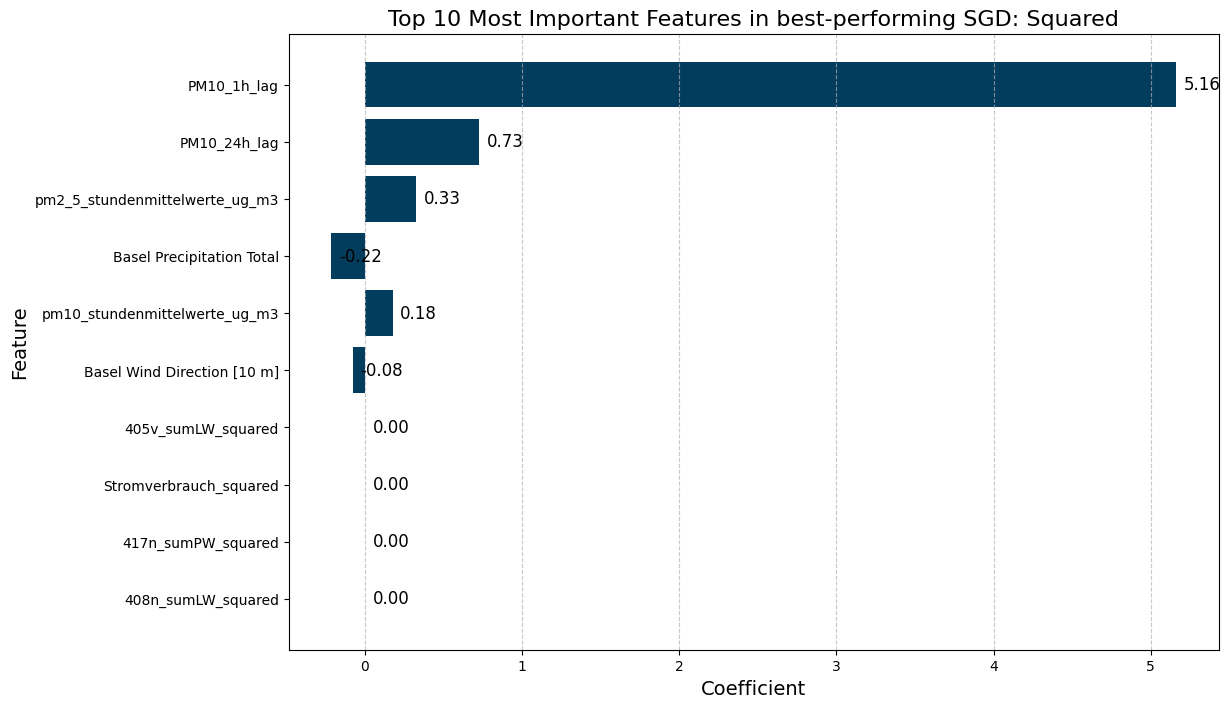

In [16]:
import matplotlib.pyplot as plt

# Extract the best estimator
best_estimator = grid_search.best_estimator_

# Get the feature names
feature_names = features.columns

# Get the coefficients (betas)
coefficients = best_estimator.coef_

# Create a DataFrame to hold feature names and their corresponding coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Plot the top 10 most important features
top_features = coef_df.head(10)
plt.figure(figsize=(12, 8))
bars = plt.barh(top_features['Feature'], top_features['Coefficient'], color='#033D5D')
plt.xlabel('Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Most Important Features in best-performing SGD: Squared', fontsize=16)
plt.gca().invert_yaxis()

# Add data labels with some space
for bar in bars:
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
             va='center', ha='left', fontsize=12, color='black')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(test_target, predictions, alpha=0.5, color='#033D5D')
plt.plot([test_target.min(), test_target.max()], [test_target.min(), test_target.max()], 'r--', lw=2, color='black')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SGD Regressor with squared features: Predicted vs Actual Test Values')
plt.legend(['Predicted vs Actual', 'Perfect Fit'])
plt.grid(True)
plt.show()